# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook w're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition:

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data:

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

+ Train.csv is the training set, which contains data through the end of 2011.
+ Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
+ Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation:

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features:

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

In [2]:
# Import training and validation data sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

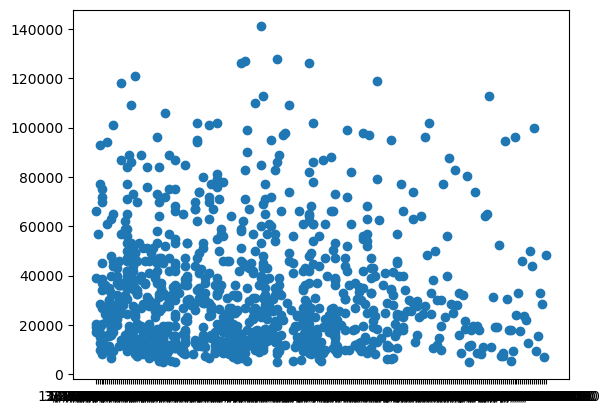

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

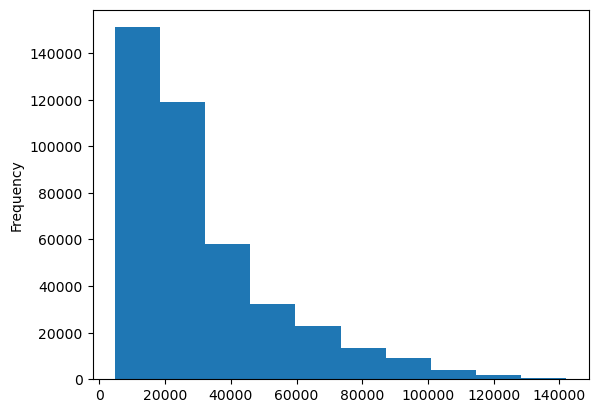

In [7]:
df["SalePrice"].plot.hist();

## Parsing Dates

When we work with time series data, we want to enrich the time and date components as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [8]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

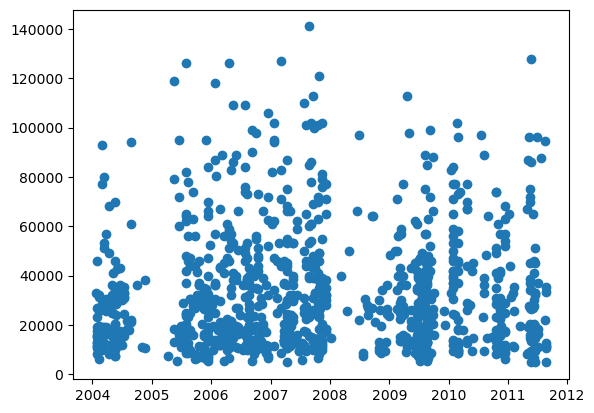

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# If we have a lot of features in our data frame jupyter truncates it, but if you want to see all you can Transpose it
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [15]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"],
               ascending=True,
               inplace=True)

df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


## Make a copy of original dataframe

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [17]:
df_tmp = df.copy()

In [18]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Add datetime parameteres for `saledate` column

In [19]:
df_tmp["saleYear"] = df_tmp["saledate"].dt.year
df_tmp["saleMonth"] = df_tmp["saledate"].dt.month
df_tmp["saleDay"] = df_tmp["saledate"].dt.day
df_tmp["saleDayOfYear"] = df_tmp["saledate"].dt.dayofyear
df_tmp["saleDayOfWeek"] = df_tmp["saledate"].dt.dayofweek

In [20]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [21]:
# Now we've enriched our dataframe with datetime features, we can remove saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [22]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [23]:
# Check the values of different columns
df_tmp["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [24]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,17,1
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31,1
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,31,1


In [25]:
len(df_tmp)

412698

In [ ]:
df_tmp.dtypes

In [ ]:
df_tmp.isna().sum()

### Converting strings to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/version/1.4/reference/general_utility_functions.html

In [27]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [28]:
not pd.api.types.is_numeric_dtype(df_tmp["UsageBand"])

True

In [29]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

In [30]:
df_tmp["UsageBand"].dtype

dtype('O')

In [31]:
df_tmp[df_tmp["UsageBand"].isna()].T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B,D6C,IT12,544,D5HII,12F,...,544H,317,S175,WA320,710VHP,D38E,2064,337G,12G,544H


In [32]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [33]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}\n"+
          f"this is a value: {value}")

this is a key: key1
this is a value: hello
this is a key: key2
this is a value: world!


In [34]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()
        #df_tmp[label] = df_tmp[label].astype("category")

In [35]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [36]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [37]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [38]:
# Check missing data
df_tmp.isna().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save Processed Data

In [39]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
              index = False)

In [40]:
# import processed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                    low_memory=False)

In [41]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [42]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [43]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

## Fill missisng values

### Fill numeric missing values first

In [44]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfYear
saleDayOfWeek


In [45]:
df_tmp[df_tmp["auctioneerID"].isna()]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek
154248,2357213,37000.0,1702442,22172,136,NaN,2003,9044.0,High,750CIILGP,...,None or Unspecified,Semi U,None or Unspecified,NaN,NaN,2003,12,8,342,0
222492,2331246,21500.0,1700283,8265,136,NaN,1000,0.0,NaN,670,...,NaN,NaN,NaN,NaN,NaN,2007,3,14,73,2
222506,2410578,22000.0,1386646,198,136,NaN,1000,0.0,NaN,D32P-1,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2007,3,14,73,2
222512,2338305,48000.0,1705197,4701,136,NaN,1999,5900.0,Medium,544H,...,NaN,NaN,NaN,Standard,Conventional,2007,3,14,73,2
222533,2274219,36000.0,1779952,4139,136,NaN,1976,0.0,NaN,D7G,...,None or Unspecified,Semi U,None or Unspecified,NaN,NaN,2007,3,14,73,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329154,2349938,19500.0,1736651,4605,136,NaN,2004,0.0,NaN,310G,...,NaN,NaN,NaN,NaN,NaN,2009,11,20,324,4
329159,4512355,15000.0,2386404,3546,136,NaN,1994,NaN,NaN,426B,...,NaN,NaN,NaN,NaN,NaN,2009,11,20,324,4
332368,2409297,50000.0,1450608,16673,136,NaN,2004,5667.0,Medium,WA200-5,...,NaN,NaN,NaN,Standard,Conventional,2009,12,17,351,3
332415,2414763,27000.0,1380548,9106,136,NaN,2003,3482.0,Medium,WA180,...,NaN,NaN,NaN,Standard,Conventional,2009,12,17,351,3


In [46]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [47]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [48]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [49]:
# Demonstrate how median is more robust than mean can efficiently handle outliers
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [50]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [51]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [52]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [53]:
# Check for columns which aren't numeric
for labels, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(labels)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [54]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [55]:
pd.Categorical(df_tmp["state"]).codes+1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [56]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [57]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [58]:
pd.Categorical(df_tmp["UsageBand"]).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [59]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric as well as our dataframe has no missing value we should be able to build a machine learning model

## 5. Modeling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [60]:
len(df_tmp)

412698

In [63]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: total: 41min 55s
Wall time: 3min 5s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [64]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875535765185894

**Question:** Why doesn't the above metric hold water? (why isn't the metric reliable)

## Splitting data into train / validation sets

In [65]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [66]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [67]:
# Split data into training and validation

df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [68]:
(len(df_val)/len(df_tmp)) * 100, (len(df_train)/len(df_tmp)) * 100

(2.8042297273066503, 97.19577027269335)

In [69]:
# Split data into X and y

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [70]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

## Building an evaluation function

In [71]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_true, y_preds):
    """
    Calcculate root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    
    scores = {"Train MAE" : mean_absolute_error(y_train, train_preds),
              "Valid MAE" : mean_absolute_error(y_valid, val_preds),
              "Train RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Train R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

In [72]:
# # This takes far too long... for experimenting

# %%time
# model = RandomForestRegressor(n_jobs=-1, 
#                               random_state=42)

# model.fit(X_train, y_train)


In [73]:
len(X_train)

401125

In [74]:
# Change max_samples value

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [75]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: total: 55.3 s
Wall time: 4.11 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [76]:
show_scores(model)

{'Train MAE': 5561.138281258958,
 'Valid MAE': 7171.251002333016,
 'Train RMSLE': 0.2577410303930966,
 'Valid RMSLE': 0.2930925556053619,
 'Train R^2': 0.860649958144041,
 'Valid R^2': 0.832162894701184}

### Hyperparameter tuning with RandomizedSearchCV

In [77]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Initialize RandomizedSearchCV model
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearch model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 13.6 s
Wall time: 50.8 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [78]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

In [79]:
# Evaluate the RandomizedSearchCV
show_scores(rs_model)

{'Train MAE': 7038.24314139731,
 'Valid MAE': 8080.249289093692,
 'Train RMSLE': 0.31313979862667674,
 'Valid RMSLE': 0.3293228075321881,
 'Train R^2': 0.7910781012723401,
 'Valid R^2': 0.798536009668072}

### Train a model with best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [80]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 4min 41s
Wall time: 22.7 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [81]:
# Scores for ideal model
show_scores(ideal_model)

{'Train MAE': 2951.890756700501,
 'Valid MAE': 5969.165323345881,
 'Train RMSLE': 0.14462583722939487,
 'Valid RMSLE': 0.24663841252433094,
 'Train R^2': 0.9588959217158949,
 'Valid R^2': 0.881710934954598}

## Make predictions on test data

In [82]:
# Import the test data

df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [85]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [86]:
len(df_test)

12457

In [87]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [88]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

## Preprocessing the data (getting our test dataset in the same format as our training dataset)

In [89]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfYear"] = df["saledate"].dt.dayofyear
    df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [90]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [91]:
df_test.head().columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=101)

In [93]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [94]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [95]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [97]:
# Ensure that the columns in both datasets are in the same order. If not, you can re-order them.
df_test = df_test[X_train.columns]
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [98]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [99]:
test_preds

array([18014.73165285, 16419.09710656, 50209.13524341, ...,
       12649.93261199, 15933.42591452, 28947.03281667])

In [100]:
len(test_preds)

12457

We've made some predictions but they're not in the same format Kaggle is asking for:

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [101]:
# Format prediction into the same format kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds

In [102]:
df_preds

,SalesID,SalesPrice
0,1227829,18014.731653
1,1227844,16419.097107
2,1227847,50209.135243
3,1227848,65926.361184
4,1227863,59296.671282
...,...,...
12452,6643171,47379.340097
12453,6643173,11197.425404
12454,6643184,12649.932612
12455,6643186,15933.425915


In [103]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_prediction.csv")

## Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice)

In [104]:
# Find feature importance for our best model
ideal_model.feature_importances_

array([3.40118086e-02, 1.78445053e-02, 4.13741837e-02, 2.00722379e-03,
       3.35133563e-03, 2.09606754e-01, 3.20537432e-03, 1.07716828e-03,
       4.12695641e-02, 5.13611702e-02, 5.95901259e-02, 4.52661351e-03,
       1.68313943e-02, 1.60962162e-01, 4.60593447e-02, 5.88666385e-03,
       2.33928710e-03, 2.85857266e-03, 3.68865682e-03, 5.14996011e-02,
       7.42341162e-04, 7.74232475e-05, 1.34800290e-03, 1.73095211e-04,
       1.06545608e-03, 2.45475504e-05, 2.03184947e-03, 4.56346248e-03,
       2.60535365e-04, 2.22528348e-03, 4.45748952e-03, 1.32649090e-03,
       3.49813517e-03, 1.23719917e-03, 2.74525292e-04, 7.12009135e-03,
       7.91756939e-04, 1.47410152e-02, 1.68726540e-03, 1.49964100e-03,
       5.90586639e-04, 8.59783678e-04, 1.61386844e-03, 6.16918635e-04,
       8.08519624e-04, 3.58455014e-04, 2.92088600e-04, 2.62663936e-03,
       9.68963989e-04, 2.05437530e-04, 3.29199569e-04, 7.36797004e-02,
       3.76309243e-03, 5.68023884e-03, 9.82142412e-03, 2.93126783e-03,
      

In [105]:
len(ideal_model.feature_importances_)

102

In [106]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

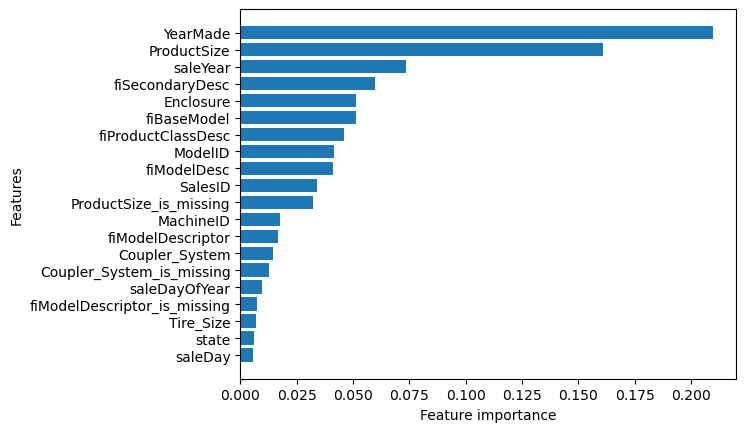

In [107]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [108]:
df["Enclosure"].value_counts()

Enclosure
OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: count, dtype: int64